# Train

In [ ]:
from custom_transformers import (
    ModifiedBertForSequenceClassification,
    SQLDataset,
    BCEFocalLossWithLogits,
    Trainer,
    AutoTokenizer,
    get_scheduler,
)
from torch.utils.data import (
    DataLoader,
    Subset,
)
from dotenv import load_dotenv
import os
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
load_dotenv()

model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    # device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained('/home/Models/TookaBERT-Base/')

connection_params = {
    'dbname': os.getenv('DBNAME'),
    'user': os.getenv('USERNAME'),
    'password': os.getenv('PASS'),
    'host': os.getenv('HOST', 'localhost'),
    'port': os.getenv('PORT', '5432')
}
dataset = SQLDataset(
    tokenizer,
    connection_params=connection_params,
    num_classes=163
)

Some weights of ModifiedBertForSequenceClassification were not initialized from the model checkpoint at /home/Models/TookaBERT-Base/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


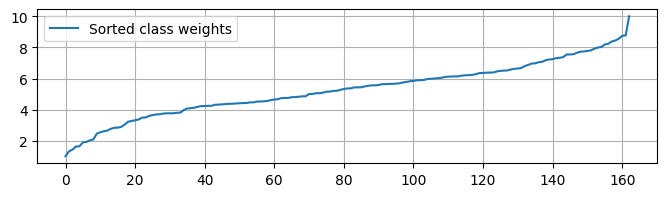

In [3]:
plt.figure(figsize=(8,2))
plt.plot(sorted(dataset.scaled_class_weights), label= 'Sorted class weights')
plt.legend()
plt.grid()
plt.show()

In [4]:
train_indices, test_indices = train_test_split(
    list(dataset.id_map.keys()),
    test_size=0.1,
)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, 32, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)
test_loader = DataLoader(test_dataset, 32, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)


# optimizer = AdamW(model.parameters(), lr=5e-5)
#--------------------------------------------------------------------------------------------------------------#
# Define the parameters for the frozen and unfrozen layers
frozen_params = []
unfrozen_params = []

for name, param in model.named_parameters():
    if name in ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']:
        # These layers will have their own learning rate
        unfrozen_params.append(param)
    else:
        # Freezing other layers (don't update their gradients)
        frozen_params.append(param)
optimizer = torch.optim.AdamW(
    [
        {'params': frozen_params, 'lr': 5e-6},   # Frozen layers have a smaller learning rate
        {'params': unfrozen_params, 'lr': 5e-5},  # Unfrozen layers have a larger learning rate
    ],
)
#--------------------------------------------------------------------------------------------------------------#

loss_fn = BCEFocalLossWithLogits(gamma=2, alpha=0.957, class_weights=dataset.scaled_class_weights.to(model.device), reduction="mean")

num_epochs = 20
num_training_steps = len(train_loader) * num_epochs 
warmup_steps = int(0.1 * num_training_steps)

scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

trainer = Trainer(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    test_loader
)

In [6]:
trainer.fit(num_epochs)

Epoch   1/20


Training Loss: 0.1283
Validation Loss: 0.0698

Epoch   2/20


Training Loss: 0.0644
Validation Loss: 0.0565

Epoch   3/20


Training Loss: 0.0552
Validation Loss: 0.0521

Epoch   4/20


Training Loss: 0.0500
Validation Loss: 0.0502

Epoch   5/20


Training Loss: 0.0463
Validation Loss: 0.0491

Epoch   6/20


Training Loss: 0.0433
Validation Loss: 0.0473

Epoch   7/20


Training Loss: 0.0407
Validation Loss: 0.0466

Epoch   8/20


Training Loss: 0.0386
Validation Loss: 0.0463

Epoch   9/20


Training Loss: 0.0367
Validation Loss: 0.0459

Epoch  10/20


Training Loss: 0.0351
Validation Loss: 0.0461

Epoch  11/20


Training Loss: 0.0337
Validation Loss: 0.0456

Epoch  12/20


Training Loss: 0.0325
Validation Loss: 0.0452

Epoch  13/20


Training Loss: 0.0315
Validation Loss: 0.0460

Epoch  14/20


Training Loss: 0.0307
Validation Loss: 0.0461

Epoch  15/20


Training Loss: 0.0300
Validation Loss: 0.0463

Epoch  16/20


Training Loss: 0.0295
Validation Loss: 0.0461

Epoch  17/20


Training Loss: 0.0291
Validation Loss: 0.0462

Epoch  18/20


Training Loss: 0.0288
Validation Loss: 0.0462

Epoch  19/20


Training Loss: 0.0286
Validation Loss: 0.0460

Epoch  20/20


Training Loss: 0.0286
Validation Loss: 0.0461



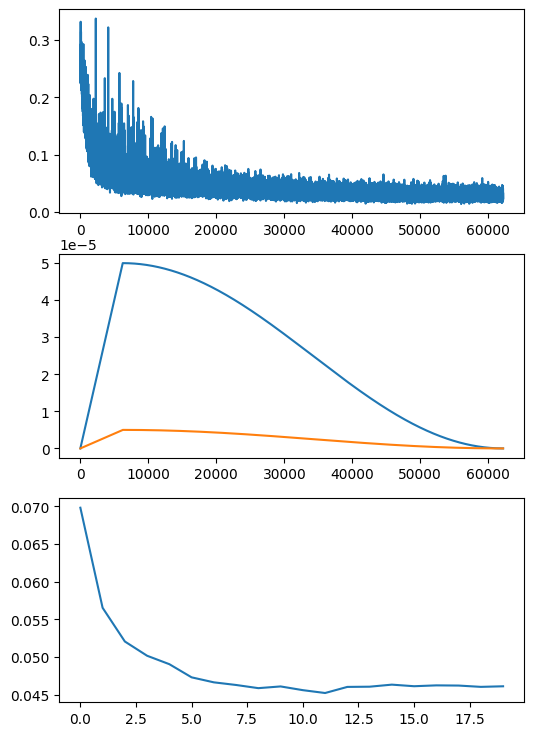

In [7]:
plt.figure(figsize=(6, 9))
plt.subplot(3, 1, 1)
plt.plot([loss for losses in trainer.losses for loss in losses])
plt.subplot(3, 1, 2)
plt.plot([lr[1] for lr in trainer.learning_rates])
plt.plot([lr[0] for lr in trainer.learning_rates])
plt.subplot(3, 1, 3)
plt.plot(trainer.validation_loss)

In [ ]:
dataset.tokenizer.save_pretrained('./saved_models/myBERT-Base3/')
trainer.model.save_pretrained('./saved_models/myBERT-Base3/', safe_serialization=True)
trainer.model.save_pretrained('./saved_models/myBERT-Base3/', safe_serialization=False)

# Check

In [10]:
from custom_transformers import (
    ModifiedBertForSequenceClassification,
    AutoTokenizer
)
import torch

In [11]:
model = ModifiedBertForSequenceClassification.from_pretrained(
    './saved_models/myBERT-Base3/',
    num_labels=163,
    # device_map='auto',
).eval()

tokenizer = AutoTokenizer.from_pretrained('./saved_models/myBERT-Base3/')

In [12]:
# %%timeit
tokens = tokenizer(
    'ارایه کلیه خدمات مهندسی کشاورزی شامل مشاوره اجرا نظارت بر اجرای انواع طرحهای ابیاری قطره ای بارانی تحت فشار و برقی کردن چاه های کشاورزی جهت بهبود عملیات زراعی در مزارع کشاورزی و باغات و تسطیح و اماده سازی و ابخیزداری و زهکشی کلیه زمینهای کشاورزی باغداری ایجاد فضای سبز گلخانه های فضای ازاد تهیه تولید تکثیر و پرورش گلهای اپارتمانی و انواع نهال تهیه تولید خرید فروش بسته بندی واردات صادرات انواع کودهای شیمیایی انواع بذر و نشا و کمپوست و سموم نباتی و ماشین الات کشاورزی و دامپروری ارایه خدمات مشاوره در زمینه بهبود عملیات زراعی و باغداری شناسایی و ردیابی افات زراعی و از بین بردن این افات بصورت علمی شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه امور بازرگانی شامل واردات صادرات ترخیص حق العمل کاری کلیه کالاهای مجاز از کلیه گمرکات و بنادر کشور و شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه عملیات اجرایی انواع طرحهای مخابراتی تاسیساتی ساختمانی راهسازی و گاز رسانی ابرسانی شهری و روستایی صنعتی شامل حفاری کابل کشی لوله گذاری کانال سازی خاکبرداری و جدول کشی انجام کلیه امور پروژه های ساختمانی مسکونی اسفالت کاری اسکلت سازی و محوطه سازی و تخریب و خاکبرداری خاکریزی و پی کنی دیوار چینی کلیه امور نقشه کشی (Gps – GPRS) کلیه امور اسنادی (خدمات اسنادی قبض انبار منطقه ویژه اصلاحیه مانیفست صورتحساب مجوز خروج کالا (بیجک) تسویه و صورت مجالس شناور صورت وضعیت خروج شناور)',
    truncation=True,
    padding=True,
    return_tensors='pt'
)

with torch.no_grad():
    output = model(**tokens.to(model.device))

lables = torch.argwhere(torch.sigmoid(output.logits[0]) > 0.4).view(-1).tolist()
print(lables)

[8, 9, 26, 29, 31, 40, 85, 102, 118, 142, 159, 162]
